In [7]:
from sklearn import datasets
X, y = datasets.make_friedman1(n_samples=150000, n_features=10, noise=0.2)

In [8]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
history = lr.fit(X, y)
print("train", history.score(X_train, y_train))
print("test", history.score(X_test, y_test))

train 0.7524131842882931
test 0.7523174282501971


In [10]:
import pandas as pd
test_lr = pd.DataFrame({'true': y_test, 'predicted': lr.predict(X_test)})
test_lr

,true,predicted
0,21.141364,17.201496
1,11.546404,18.729231
2,11.655838,12.207512
3,12.784364,15.562510
4,13.139686,13.868496
...,...,...
44995,16.954108,15.551330
44996,15.828484,16.822636
44997,22.742332,17.618603
44998,11.172250,13.171197


In [11]:
from sklearn import metrics

def get_metrics(index, y_train_true, y_train_pred, y_test_true, y_test_pred):
    return pd.DataFrame({
        'r2 train': metrics.r2_score(y_train_true, y_train_pred),
        'r2 test': metrics.r2_score(y_test_true, y_test_pred),

        'mse train': metrics.mean_squared_error(y_train_true, y_train_pred),
        'mse test': metrics.mean_squared_error(y_test_true, y_test_pred),

        'mae train': metrics.mean_absolute_error(y_train_true, y_train_pred),
        'mae test': metrics.mean_absolute_error(y_test_true, y_test_pred),

        'mape train': metrics.mean_absolute_percentage_error(y_train_true, y_train_pred),
        'mape test': metrics.mean_absolute_percentage_error(y_test_true, y_test_pred),
    }, index=index)

baseline = get_metrics([0], y_train, lr.predict(X_train), y_test, lr.predict(X_test))
baseline

,r2 train,r2 test,mse train,mse test,mae train,mae test,mape train,mape test
0,0.752413,0.752317,5.917188,5.900748,1.870122,1.865132,0.155867,0.154363


In [12]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np

class DenseNeuralNetwork(nn.Module):
    def __init__(self, layer_count):
        super(DenseNeuralNetwork, self).__init__()
        layers = [nn.Linear(10, 512), nn.ReLU()]

        for i in range(layer_count):
            layers.append(nn.Linear(512, 512))

        layers.append(nn.ReLU())
        layers.append(nn.Linear(512, 1))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [61]:
def do_work(model, optimizer, lr, epochs, X_train, y_train, X_test, y_test):
    x_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    x_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=64)
    train_loss_divider = len(train_dataloader)
    
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=64)
    test_loss_divider = len(test_dataloader)
    
    criterion = nn.MSELoss()
    
    history = pd.DataFrame(columns=['train', 'test'])

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = 0.0

        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_loss += loss.item()
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        y_train_pred = model(x_train_tensor).detach().numpy()
        y_test_pred = model(x_test_tensor).detach().numpy()
        
        if np.count_nonzero(np.isnan(y_train_pred)) == len(y_train_pred):
            print('skipping epoch history...')
            break

        print(f'[{epoch + 1}] loss: {epoch_loss / train_loss_divider}')
        
        # calc test loss
        test_loss = 0.0
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item()

        epoch_history = pd.concat([pd.DataFrame({'train': epoch_loss / train_loss_divider, 'test': test_loss / test_loss_divider}, index=[epoch+1]), get_metrics([epoch + 1], y_train_tensor, y_train_pred, y_test_tensor, y_test_pred)], axis=1)
        
        history = pd.concat([history, epoch_history])
        
    return history

In [64]:
histories = {}

for netw_i, layers in enumerate([1, 5, 25]):
    for opt_i, optimizer in enumerate([optim.SGD, optim.RMSprop, optim.Adam]):
        for lr in [0.1, 0.01, 0.001]:
            netw = DenseNeuralNetwork(layers)
            o = optimizer(netw.parameters(), lr=lr)
            dnn_name = f'DNN{netw_i + 1}-OPT{opt_i + 1}-lr={lr}'
            print(f'doing {dnn_name}')
            history = do_work(netw, o, lr, 5, X_train, y_train, X_test, y_test)
            histories[dnn_name] = history
            torch.save(netw.state_dict(), f'saved/{dnn_name}.pth')
            history.to_csv(f'saved/{dnn_name}.csv')

doing DNN1-OPT1-lr=0.1


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


skipping epoch history...
doing DNN1-OPT1-lr=0.01
[1,   100] loss: 42.820
[1,   200] loss: 26.107
[1,   300] loss: 24.274
[1,   400] loss: 25.129
[1,   500] loss: 24.529
[1,   600] loss: 24.475
[1,   700] loss: 24.373
[1,   800] loss: 24.901
[1,   900] loss: 23.797
[1,  1000] loss: 24.541
[1,  1100] loss: 24.330
[1,  1200] loss: 24.138
[1,  1300] loss: 24.629
[1,  1400] loss: 24.242
[1,  1500] loss: 24.231
[1,  1600] loss: 24.709
[1] loss: 25.63805293223249


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.247
[2,   200] loss: 23.304
[2,   300] loss: 23.309
[2,   400] loss: 24.286
[2,   500] loss: 23.641
[2,   600] loss: 23.799
[2,   700] loss: 23.977
[2,   800] loss: 24.533
[2,   900] loss: 23.575
[2,  1000] loss: 24.379
[2,  1100] loss: 24.201
[2,  1200] loss: 24.023
[2,  1300] loss: 24.525
[2,  1400] loss: 24.175
[2,  1500] loss: 24.178
[2,  1600] loss: 24.634


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.02631969672743


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.211
[3,   200] loss: 23.261
[3,   300] loss: 23.287
[3,   400] loss: 24.275
[3,   500] loss: 23.620
[3,   600] loss: 23.778
[3,   700] loss: 23.959
[3,   800] loss: 24.515
[3,   900] loss: 23.562
[3,  1000] loss: 24.368
[3,  1100] loss: 24.189
[3,  1200] loss: 24.013
[3,  1300] loss: 24.513
[3,  1400] loss: 24.166
[3,  1500] loss: 24.169
[3,  1600] loss: 24.620


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.00913399330804


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.202
[4,   200] loss: 23.250
[4,   300] loss: 23.281
[4,   400] loss: 24.271
[4,   500] loss: 23.613
[4,   600] loss: 23.771
[4,   700] loss: 23.952
[4,   800] loss: 24.508
[4,   900] loss: 23.558
[4,  1000] loss: 24.363
[4,  1100] loss: 24.183
[4,  1200] loss: 24.008
[4,  1300] loss: 24.507
[4,  1400] loss: 24.161
[4,  1500] loss: 24.165
[4,  1600] loss: 24.613


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.00307089929389


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.198
[5,   200] loss: 23.244
[5,   300] loss: 23.277
[5,   400] loss: 24.270
[5,   500] loss: 23.609
[5,   600] loss: 23.767
[5,   700] loss: 23.948
[5,   800] loss: 24.504
[5,   900] loss: 23.554
[5,  1000] loss: 24.360
[5,  1100] loss: 24.180
[5,  1200] loss: 24.004
[5,  1300] loss: 24.503
[5,  1400] loss: 24.158
[5,  1500] loss: 24.162
[5,  1600] loss: 24.607


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 23.999243115594226


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT1-lr=0.001
[1,   100] loss: 43.088
[1,   200] loss: 25.278
[1,   300] loss: 24.819
[1,   400] loss: 25.489
[1,   500] loss: 24.467
[1,   600] loss: 24.353
[1,   700] loss: 24.334
[1,   800] loss: 24.764
[1,   900] loss: 23.737
[1,  1000] loss: 24.459
[1,  1100] loss: 24.247
[1,  1200] loss: 24.048
[1,  1300] loss: 24.540
[1,  1400] loss: 24.191
[1,  1500] loss: 24.185
[1,  1600] loss: 24.625


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 25.601229509589587


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.213
[2,   200] loss: 23.267
[2,   300] loss: 23.298
[2,   400] loss: 24.286
[2,   500] loss: 23.627
[2,   600] loss: 23.783
[2,   700] loss: 23.956
[2,   800] loss: 24.519
[2,   900] loss: 23.572
[2,  1000] loss: 24.371
[2,  1100] loss: 24.192
[2,  1200] loss: 24.014
[2,  1300] loss: 24.514
[2,  1400] loss: 24.173
[2,  1500] loss: 24.172
[2,  1600] loss: 24.616


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.013448730319976


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.203
[3,   200] loss: 23.254
[3,   300] loss: 23.288
[3,   400] loss: 24.279
[3,   500] loss: 23.618
[3,   600] loss: 23.774
[3,   700] loss: 23.947
[3,   800] loss: 24.509
[3,   900] loss: 23.564
[3,  1000] loss: 24.364
[3,  1100] loss: 24.184
[3,  1200] loss: 24.007
[3,  1300] loss: 24.506
[3,  1400] loss: 24.166
[3,  1500] loss: 24.165
[3,  1600] loss: 24.607


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.004834250078776


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.196
[4,   200] loss: 23.246
[4,   300] loss: 23.281
[4,   400] loss: 24.274
[4,   500] loss: 23.612
[4,   600] loss: 23.768
[4,   700] loss: 23.941
[4,   800] loss: 24.503
[4,   900] loss: 23.558
[4,  1000] loss: 24.359
[4,  1100] loss: 24.179
[4,  1200] loss: 24.002
[4,  1300] loss: 24.501
[4,  1400] loss: 24.161
[4,  1500] loss: 24.161
[4,  1600] loss: 24.601


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 23.999117443868112


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.191
[5,   200] loss: 23.240
[5,   300] loss: 23.276
[5,   400] loss: 24.272
[5,   500] loss: 23.608
[5,   600] loss: 23.764
[5,   700] loss: 23.937
[5,   800] loss: 24.498
[5,   900] loss: 23.554
[5,  1000] loss: 24.356
[5,  1100] loss: 24.175
[5,  1200] loss: 23.999
[5,  1300] loss: 24.497
[5,  1400] loss: 24.157
[5,  1500] loss: 24.157
[5,  1600] loss: 24.595


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 23.99501068166376


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT2-lr=0.1
[1,   100] loss: 661538251.619
[1,   200] loss: 277.312
[1,   300] loss: 286.574
[1,   400] loss: 212.226
[1,   500] loss: 312.030
[1,   600] loss: 496.196
[1,   700] loss: 28.737
[1,   800] loss: 120.534
[1,   900] loss: 65.832
[1,  1000] loss: 50.232
[1,  1100] loss: 35.369
[1,  1200] loss: 28.891
[1,  1300] loss: 26.964
[1,  1400] loss: 26.944
[1,  1500] loss: 27.152
[1,  1600] loss: 26.450


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 40313240.91679243


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 27.026
[2,   200] loss: 26.745
[2,   300] loss: 26.566
[2,   400] loss: 32.954
[2,   500] loss: 26.065
[2,   600] loss: 41.110
[2,   700] loss: 45.650
[2,   800] loss: 25.505
[2,   900] loss: 24.254
[2,  1000] loss: 25.119
[2,  1100] loss: 25.207
[2,  1200] loss: 25.434
[2,  1300] loss: 25.640
[2,  1400] loss: 24.842
[2,  1500] loss: 24.785
[2,  1600] loss: 25.261


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 28.13729797900268


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.534
[3,   200] loss: 23.441
[3,   300] loss: 23.345
[3,   400] loss: 24.318
[3,   500] loss: 79.339
[3,   600] loss: 23.763
[3,   700] loss: 23.821
[3,   800] loss: 24.405
[3,   900] loss: 23.470
[3,  1000] loss: 24.295
[3,  1100] loss: 24.097
[3,  1200] loss: 23.941
[3,  1300] loss: 24.437
[3,  1400] loss: 24.108
[3,  1500] loss: 24.097
[3,  1600] loss: 24.482


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 27.383488202952236


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.127
[4,   200] loss: 23.145
[4,   300] loss: 23.220
[4,   400] loss: 24.256
[4,   500] loss: 23.558
[4,   600] loss: 23.708
[4,   700] loss: 23.856
[4,   800] loss: 24.428
[4,   900] loss: 23.489
[4,  1000] loss: 24.305
[4,  1100] loss: 24.104
[4,  1200] loss: 23.944
[4,  1300] loss: 24.438
[4,  1400] loss: 24.108
[4,  1500] loss: 24.097
[4,  1600] loss: 24.482


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 23.932623956786067


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.127
[5,   200] loss: 23.145
[5,   300] loss: 23.220
[5,   400] loss: 24.256
[5,   500] loss: 23.558
[5,   600] loss: 23.708
[5,   700] loss: 23.856
[5,   800] loss: 24.428
[5,   900] loss: 23.489
[5,  1000] loss: 24.305
[5,  1100] loss: 24.104
[5,  1200] loss: 23.944
[5,  1300] loss: 24.438
[5,  1400] loss: 24.108
[5,  1500] loss: 24.097
[5,  1600] loss: 24.482


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 23.93262463150629


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT2-lr=0.01
[1,   100] loss: 1696.719
[1,   200] loss: 24.466
[1,   300] loss: 24.010
[1,   400] loss: 25.028
[1,   500] loss: 24.607
[1,   600] loss: 24.884
[1,   700] loss: 24.749
[1,   800] loss: 26.061
[1,   900] loss: 24.967
[1,  1000] loss: 26.518
[1,  1100] loss: 26.388
[1,  1200] loss: 26.451
[1,  1300] loss: 26.463
[1,  1400] loss: 25.704
[1,  1500] loss: 25.620
[1,  1600] loss: 26.154


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 127.28631581510443


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 25.413
[2,   200] loss: 24.528
[2,   300] loss: 24.050
[2,   400] loss: 25.183
[2,   500] loss: 24.726
[2,   600] loss: 24.764
[2,   700] loss: 24.630
[2,   800] loss: 25.474
[2,   900] loss: 24.141
[2,  1000] loss: 25.009
[2,  1100] loss: 24.751
[2,  1200] loss: 24.856
[2,  1300] loss: 25.263
[2,  1400] loss: 24.695
[2,  1500] loss: 24.675
[2,  1600] loss: 25.286


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.807886689120426


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.678
[3,   200] loss: 23.859
[3,   300] loss: 23.699
[3,   400] loss: 24.659
[3,   500] loss: 24.247
[3,   600] loss: 24.279
[3,   700] loss: 24.306
[3,   800] loss: 24.985
[3,   900] loss: 23.871
[3,  1000] loss: 24.681
[3,  1100] loss: 24.477
[3,  1200] loss: 24.404
[3,  1300] loss: 24.905
[3,  1400] loss: 24.468
[3,  1500] loss: 24.449
[3,  1600] loss: 24.962


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.4092716360005


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.460
[4,   200] loss: 23.525
[4,   300] loss: 23.427
[4,   400] loss: 24.411
[4,   500] loss: 23.842
[4,   600] loss: 23.987
[4,   700] loss: 24.099
[4,   800] loss: 24.725
[4,   900] loss: 23.685
[4,  1000] loss: 24.484
[4,  1100] loss: 24.305
[4,  1200] loss: 24.146
[4,  1300] loss: 24.647
[4,  1400] loss: 24.271
[4,  1500] loss: 24.276
[4,  1600] loss: 24.742


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.16468427473274


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.323
[5,   200] loss: 23.334
[5,   300] loss: 23.328
[5,   400] loss: 24.308
[5,   500] loss: 23.675
[5,   600] loss: 23.815
[5,   700] loss: 23.976
[5,   800] loss: 24.557
[5,   900] loss: 23.571
[5,  1000] loss: 24.379
[5,  1100] loss: 24.195
[5,  1200] loss: 24.020
[5,  1300] loss: 24.520
[5,  1400] loss: 24.170
[5,  1500] loss: 24.171
[5,  1600] loss: 24.616


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.036664098010856


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT2-lr=0.001
[1,   100] loss: 29.512
[1,   200] loss: 24.234
[1,   300] loss: 23.832
[1,   400] loss: 24.824
[1,   500] loss: 24.337
[1,   600] loss: 24.412
[1,   700] loss: 24.386
[1,   800] loss: 25.096
[1,   900] loss: 23.965
[1,  1000] loss: 24.778
[1,  1100] loss: 24.585
[1,  1200] loss: 24.542
[1,  1300] loss: 25.025
[1,  1400] loss: 24.530
[1,  1500] loss: 24.544
[1,  1600] loss: 25.126


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 24.821277342359878


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.568
[2,   200] loss: 23.729
[2,   300] loss: 23.551
[2,   400] loss: 24.561
[2,   500] loss: 24.057
[2,   600] loss: 24.185
[2,   700] loss: 24.236
[2,   800] loss: 24.891
[2,   900] loss: 23.831
[2,  1000] loss: 24.641
[2,  1100] loss: 24.459
[2,  1200] loss: 24.371
[2,  1300] loss: 24.870
[2,  1400] loss: 24.422
[2,  1500] loss: 24.432
[2,  1600] loss: 24.986


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.33545081459989


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.461
[3,   200] loss: 23.603
[3,   300] loss: 23.481
[3,   400] loss: 24.473
[3,   500] loss: 23.942
[3,   600] loss: 24.083
[3,   700] loss: 24.170
[3,   800] loss: 24.793
[3,   900] loss: 23.770
[3,  1000] loss: 24.573
[3,  1100] loss: 24.397
[3,  1200] loss: 24.285
[3,  1300] loss: 24.786
[3,  1400] loss: 24.363
[3,  1500] loss: 24.375
[3,  1600] loss: 24.905


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.253518294009545


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.403
[4,   200] loss: 23.528
[4,   300] loss: 23.442
[4,   400] loss: 24.427
[4,   500] loss: 23.878
[4,   600] loss: 24.024
[4,   700] loss: 24.131
[4,   800] loss: 24.738
[4,   900] loss: 23.732
[4,  1000] loss: 24.535
[4,  1100] loss: 24.363
[4,  1200] loss: 24.233
[4,  1300] loss: 24.740
[4,  1400] loss: 24.331
[4,  1500] loss: 24.343
[4,  1600] loss: 24.859


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.206967907660914


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.369
[5,   200] loss: 23.482
[5,   300] loss: 23.417
[5,   400] loss: 24.399
[5,   500] loss: 23.839
[5,   600] loss: 23.992
[5,   700] loss: 24.109
[5,   800] loss: 24.705
[5,   900] loss: 23.706
[5,  1000] loss: 24.511
[5,  1100] loss: 24.342
[5,  1200] loss: 24.199
[5,  1300] loss: 24.711
[5,  1400] loss: 24.308
[5,  1500] loss: 24.318
[5,  1600] loss: 24.825


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.177611538726044


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT3-lr=0.1
[1,   100] loss: 1306.177
[1,   200] loss: 23.674
[1,   300] loss: 23.437
[1,   400] loss: 24.533
[1,   500] loss: 24.075
[1,   600] loss: 24.093
[1,   700] loss: 24.558
[1,   800] loss: 24.684
[1,   900] loss: 23.980
[1,  1000] loss: 24.578
[1,  1100] loss: 24.323
[1,  1200] loss: 24.729
[1,  1300] loss: 24.573
[1,  1400] loss: 24.381
[1,  1500] loss: 24.896
[1,  1600] loss: 24.785


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 102.4410036692599


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.412
[2,   200] loss: 23.595
[2,   300] loss: 23.438
[2,   400] loss: 24.556
[2,   500] loss: 24.038
[2,   600] loss: 23.971
[2,   700] loss: 24.263
[2,   800] loss: 24.641
[2,   900] loss: 24.070
[2,  1000] loss: 24.518
[2,  1100] loss: 24.191
[2,  1200] loss: 24.626
[2,  1300] loss: 24.706
[2,  1400] loss: 24.209
[2,  1500] loss: 24.556
[2,  1600] loss: 24.740


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.25842628211673


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.350
[3,   200] loss: 23.498
[3,   300] loss: 23.438
[3,   400] loss: 24.562
[3,   500] loss: 24.038
[3,   600] loss: 23.937
[3,   700] loss: 24.207
[3,   800] loss: 24.621
[3,   900] loss: 23.989
[3,  1000] loss: 24.492
[3,  1100] loss: 24.183
[3,  1200] loss: 24.564
[3,  1300] loss: 24.732
[3,  1400] loss: 24.195
[3,  1500] loss: 24.490
[3,  1600] loss: 24.711


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.22638233168542


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.340
[4,   200] loss: 23.463
[4,   300] loss: 23.426
[4,   400] loss: 24.549
[4,   500] loss: 23.984
[4,   600] loss: 23.892
[4,   700] loss: 24.119
[4,   800] loss: 24.613
[4,   900] loss: 23.835
[4,  1000] loss: 24.450
[4,  1100] loss: 24.179
[4,  1200] loss: 24.401
[4,  1300] loss: 24.718
[4,  1400] loss: 24.186
[4,  1500] loss: 24.379
[4,  1600] loss: 24.630


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.17376050129669


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.342
[5,   200] loss: 23.385
[5,   300] loss: 23.382
[5,   400] loss: 24.509
[5,   500] loss: 23.923
[5,   600] loss: 23.851
[5,   700] loss: 24.020
[5,   800] loss: 24.592
[5,   900] loss: 23.713
[5,  1000] loss: 24.464
[5,  1100] loss: 24.202
[5,  1200] loss: 24.177
[5,  1300] loss: 24.627
[5,  1400] loss: 24.274
[5,  1500] loss: 24.229
[5,  1600] loss: 24.554


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.116526440394352


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT3-lr=0.01
[1,   100] loss: 31.556
[1,   200] loss: 23.886
[1,   300] loss: 24.291
[1,   400] loss: 25.411
[1,   500] loss: 24.413
[1,   600] loss: 24.400
[1,   700] loss: 25.635
[1,   800] loss: 24.893
[1,   900] loss: 23.999
[1,  1000] loss: 25.543
[1,  1100] loss: 24.706
[1,  1200] loss: 24.882
[1,  1300] loss: 24.825
[1,  1400] loss: 24.420
[1,  1500] loss: 24.702
[1,  1600] loss: 25.107


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 25.141921440905584


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.816
[2,   200] loss: 23.735
[2,   300] loss: 23.658
[2,   400] loss: 24.634
[2,   500] loss: 23.986
[2,   600] loss: 24.043
[2,   700] loss: 24.421
[2,   800] loss: 24.702
[2,   900] loss: 24.156
[2,  1000] loss: 24.540
[2,  1100] loss: 24.198
[2,  1200] loss: 24.635
[2,  1300] loss: 24.743
[2,  1400] loss: 24.189
[2,  1500] loss: 24.416
[2,  1600] loss: 24.643


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.317190130188436


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.327
[3,   200] loss: 23.359
[3,   300] loss: 23.373
[3,   400] loss: 24.508
[3,   500] loss: 23.879
[3,   600] loss: 23.810
[3,   700] loss: 23.941
[3,   800] loss: 24.589
[3,   900] loss: 23.660
[3,  1000] loss: 24.554
[3,  1100] loss: 24.129
[3,  1200] loss: 24.066
[3,  1300] loss: 24.564
[3,  1400] loss: 24.369
[3,  1500] loss: 24.166
[3,  1600] loss: 24.526


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.090147505439976


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.254
[4,   200] loss: 23.242
[4,   300] loss: 23.381
[4,   400] loss: 24.596
[4,   500] loss: 23.622
[4,   600] loss: 23.774
[4,   700] loss: 23.920
[4,   800] loss: 24.592
[4,   900] loss: 23.606
[4,  1000] loss: 24.544
[4,  1100] loss: 24.125
[4,  1200] loss: 24.062
[4,  1300] loss: 24.584
[4,  1400] loss: 24.365
[4,  1500] loss: 24.167
[4,  1600] loss: 24.527


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.062065420319293


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.254
[5,   200] loss: 23.238
[5,   300] loss: 23.356
[5,   400] loss: 24.575
[5,   500] loss: 23.615
[5,   600] loss: 23.773
[5,   700] loss: 23.920
[5,   800] loss: 24.592
[5,   900] loss: 23.594
[5,  1000] loss: 24.530
[5,  1100] loss: 24.120
[5,  1200] loss: 24.054
[5,  1300] loss: 24.575
[5,  1400] loss: 24.336
[5,  1500] loss: 24.158
[5,  1600] loss: 24.523


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.052910806491997


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN1-OPT3-lr=0.001
[1,   100] loss: 43.132
[1,   200] loss: 23.720
[1,   300] loss: 23.594
[1,   400] loss: 24.718
[1,   500] loss: 23.956
[1,   600] loss: 23.895
[1,   700] loss: 24.038
[1,   800] loss: 24.617
[1,   900] loss: 23.768
[1,  1000] loss: 24.459
[1,  1100] loss: 24.196
[1,  1200] loss: 24.316
[1,  1300] loss: 24.703
[1,  1400] loss: 24.198
[1,  1500] loss: 24.352
[1,  1600] loss: 24.613


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 25.338407874470583


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.327
[2,   200] loss: 23.383
[2,   300] loss: 23.383
[2,   400] loss: 24.508
[2,   500] loss: 23.922
[2,   600] loss: 23.861
[2,   700] loss: 24.034
[2,   800] loss: 24.595
[2,   900] loss: 23.748
[2,  1000] loss: 24.446
[2,  1100] loss: 24.191
[2,  1200] loss: 24.264
[2,  1300] loss: 24.673
[2,  1400] loss: 24.201
[2,  1500] loss: 24.312
[2,  1600] loss: 24.581


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.12835433350911


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.317
[3,   200] loss: 23.335
[3,   300] loss: 23.366
[3,   400] loss: 24.506
[3,   500] loss: 23.913
[3,   600] loss: 23.846
[3,   700] loss: 23.996
[3,   800] loss: 24.582
[3,   900] loss: 23.714
[3,  1000] loss: 24.459
[3,  1100] loss: 24.200
[3,  1200] loss: 24.197
[3,  1300] loss: 24.639
[3,  1400] loss: 24.227
[3,  1500] loss: 24.270
[3,  1600] loss: 24.559


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.109530070582082


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.308
[4,   200] loss: 23.297
[4,   300] loss: 23.361
[4,   400] loss: 24.537
[4,   500] loss: 23.891
[4,   600] loss: 23.834
[4,   700] loss: 23.965
[4,   800] loss: 24.575
[4,   900] loss: 23.700
[4,  1000] loss: 24.491
[4,  1100] loss: 24.196
[4,  1200] loss: 24.143
[4,  1300] loss: 24.624
[4,  1400] loss: 24.275
[4,  1500] loss: 24.232
[4,  1600] loss: 24.548


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.100536174995007


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.302
[5,   200] loss: 23.273
[5,   300] loss: 23.365
[5,   400] loss: 24.593
[5,   500] loss: 23.835
[5,   600] loss: 23.817
[5,   700] loss: 23.945
[5,   800] loss: 24.579
[5,   900] loss: 23.696
[5,  1000] loss: 24.526
[5,  1100] loss: 24.179
[5,  1200] loss: 24.109
[5,  1300] loss: 24.620
[5,  1400] loss: 24.337
[5,  1500] loss: 24.205
[5,  1600] loss: 24.542


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.09729312906027


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT1-lr=0.1
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


skipping epoch history...
doing DNN2-OPT1-lr=0.01
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan
skipping epoch history...
doing DNN2-OPT1-lr=0.001
[1,   100] loss: 69.004
[1,   200] loss: 25.653
[1,   300] loss: 24.354
[1,   400] loss: 25.293
[1,   500] loss: 24.889
[1,   600] loss: 24.955
[1,   700] loss: 24.717
[1,   800] loss: 25.384
[1,   900] loss: 24.173
[1,  1000] loss: 24.911
[1,  1100] loss: 24.676
[1,  1200] loss: 24.685
[1,  1300] loss: 25.199
[1,  1400] loss: 24.679
[1,  1500] loss: 24.612
[1,  1600] loss: 25.424
[1] loss: 27.556885365376306


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.632
[2,   200] loss: 23.868
[2,   300] loss: 23.571
[2,   400] loss: 24.540
[2,   500] loss: 24.027
[2,   600] loss: 24.183
[2,   700] loss: 24.277
[2,   800] loss: 24.882
[2,   900] loss: 23.830
[2,  1000] loss: 24.606
[2,  1100] loss: 24.411
[2,  1200] loss: 24.298
[2,  1300] loss: 24.824
[2,  1400] loss: 24.391
[2,  1500] loss: 24.376
[2,  1600] loss: 25.010


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.33044135229098


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.409
[3,   200] loss: 23.564
[3,   300] loss: 23.438
[3,   400] loss: 24.392
[3,   500] loss: 23.819
[3,   600] loss: 23.976
[3,   700] loss: 24.126
[3,   800] loss: 24.703
[3,   900] loss: 23.701
[3,  1000] loss: 24.490
[3,  1100] loss: 24.310
[3,  1200] loss: 24.149
[3,  1300] loss: 24.665
[3,  1400] loss: 24.278
[3,  1500] loss: 24.274
[3,  1600] loss: 24.816


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.16931969679252


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.308
[4,   200] loss: 23.406
[4,   300] loss: 23.362
[4,   400] loss: 24.324
[4,   500] loss: 23.713
[4,   600] loss: 23.869
[4,   700] loss: 24.039
[4,   800] loss: 24.602
[4,   900] loss: 23.628
[4,  1000] loss: 24.424
[4,  1100] loss: 24.247
[4,  1200] loss: 24.069
[4,  1300] loss: 24.577
[4,  1400] loss: 24.215
[4,  1500] loss: 24.215
[4,  1600] loss: 24.705


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.082760704500803


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.248
[5,   200] loss: 23.313
[5,   300] loss: 23.315
[5,   400] loss: 24.290
[5,   500] loss: 23.653
[5,   600] loss: 23.807
[5,   700] loss: 23.985
[5,   800] loss: 24.541
[5,   900] loss: 23.583
[5,  1000] loss: 24.385
[5,  1100] loss: 24.205
[5,  1200] loss: 24.025
[5,  1300] loss: 24.527
[5,  1400] loss: 24.177
[5,  1500] loss: 24.180
[5,  1600] loss: 24.637


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.031484483001726


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT2-lr=0.1
[1,   100] loss: 15078296294242120069845876736.000
[1,   200] loss: 15464622612923391286225928192.000
[1,   300] loss: 15456862265440678675793051648.000
[1,   400] loss: 15461311549275759560871641088.000
[1,   500] loss: 15545015093783473154286419968.000
[1,   600] loss: 15561161443278298886686375936.000
[1,   700] loss: 15463970040905039737127960576.000
[1,   800] loss: 15481205143798408328937209856.000
[1,   900] loss: 15470557187270582562392637440.000
[1,  1000] loss: 15434750610798777383681785856.000
[1,  1100] loss: 15487976580515942503278444544.000
[1,  1200] loss: 15429046263623541946010566656.000
[1,  1300] loss: 15478038997772219665820418048.000
[1,  1400] loss: 15468097164898660486463094784.000
[1,  1500] loss: 15555149233226131696458399744.000
[1,  1600] loss: 15454436633702669065625010176.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 1.5453183327824262e+28


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 15378675613770661602107850752.000
[2,   200] loss: 15447869758095256069374738432.000
[2,   300] loss: 15440128843150619324039823360.000
[2,   400] loss: 15444533500622438410385096704.000
[2,   500] loss: 15528201532934200736106938368.000
[2,   600] loss: 15544286845842234058928553984.000
[2,   700] loss: 15447341337091739339171299328.000
[2,   800] loss: 15464520090347048362150199296.000
[2,   900] loss: 15453894376165356735712722944.000
[2,  1000] loss: 15418277591602497824160219136.000
[2,  1100] loss: 15471250867489167843595911168.000
[2,  1200] loss: 15413268022596056782064320512.000
[2,  1300] loss: 15477595968960629513937485824.000
[2,  1400] loss: 15467654289563981995413864448.000
[2,  1500] loss: 15554705425224071695162146816.000
[2,  1600] loss: 15453993805591654347741069312.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 1.546022293308772e+28


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 15378234497517496044860997632.000
[3,   200] loss: 15447427850845704719423242240.000
[3,   300] loss: 15439685849756777002030858240.000
[3,   400] loss: 15444091569761055173850955776.000
[3,   500] loss: 15527757772155804507975974912.000
[3,   600] loss: 15543842919781012425695821824.000
[3,   700] loss: 15446898532592556507870003200.000
[3,   800] loss: 15464077144176872012329779200.000
[3,   900] loss: 15453452339050727810533425152.000
[3,  1000] loss: 15417836109365931427812605952.000
[3,  1100] loss: 15470807744230247946359144448.000
[3,  1200] loss: 15412825879228182168239865856.000
[3,  1300] loss: 15477153070014116937282355200.000
[3,  1400] loss: 15467211626735792682631692288.000
[3,  1500] loss: 15554261156791278910388043776.000
[3,  1600] loss: 15453550965674723686565806080.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 1.5459780301159234e+28


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 15377793215981505082512375808.000
[4,   200] loss: 15446986333191388294178406400.000
[4,   300] loss: 15439242679274193331628802048.000
[4,   400] loss: 15443649756958833569253294080.000
[4,   500] loss: 15527313916930080733514432512.000
[4,   600] loss: 15543398698571885613110263808.000
[4,   700] loss: 15446455539198714185861038080.000
[4,   800] loss: 15463634316065857294445838336.000
[4,   900] loss: 15453010254712435112188837888.000
[4,  1000] loss: 15417394060445386559341985792.000
[4,  1100] loss: 15470364880701483199577980928.000
[4,  1200] loss: 15412383322653240743126106112.000
[4,  1300] loss: 15476710501633259568877273088.000
[4,  1400] loss: 15466768857654359880227618816.000
[4,  1500] loss: 15553817761996285720381095936.000
[4,  1600] loss: 15453108491741193864491302912.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 1.5459337689374906e+28


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 15377351757356770572747407360.000
[5,   200] loss: 15446544614836498633957834752.000
[5,   300] loss: 15438799473373859632329523200.000
[5,   400] loss: 15443207460114047294595137536.000
[5,   500] loss: 15526869979062940957967122432.000
[5,   600] loss: 15542954807928411809751498752.000
[5,   700] loss: 15446012699281783524685774848.000
[5,   800] loss: 15463191417119344717790707712.000
[5,   900] loss: 15452568005091314809719226368.000
[5,  1000] loss: 15416952377508242529972125696.000
[5,  1100] loss: 15469921946337222793048883200.000
[5,  1200] loss: 15411940789690131204594991104.000
[5,  1300] loss: 15476267756163656454032588800.000
[5,  1400] loss: 15466325935096015416989843456.000
[5,  1500] loss: 15553373635234488653149372416.000
[5,  1600] loss: 15452665179587614476546867200.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 1.5458894936581465e+28


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT2-lr=0.01
[1,   100] loss: 328518020461015.750
[1,   200] loss: 554883555.200
[1,   300] loss: 227285049.760
[1,   400] loss: 241429608.000
[1,   500] loss: 63448224.880
[1,   600] loss: 57576522.080
[1,   700] loss: 11482802.887
[1,   800] loss: 66376768.319
[1,   900] loss: 35395245.224
[1,  1000] loss: 1165396582.328
[1,  1100] loss: 50131461.420
[1,  1200] loss: 141597777.190
[1,  1300] loss: 53507699.930
[1,  1400] loss: 83589904.840
[1,  1500] loss: 12833240.695
[1,  1600] loss: 25998178.369


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 20019568185663.094


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 134341.125
[2,   200] loss: 162303.585
[2,   300] loss: 646223.882
[2,   400] loss: 471883.512
[2,   500] loss: 212809.519
[2,   600] loss: 140573.089
[2,   700] loss: 6279617156770.155
[2,   800] loss: 508408060.560
[2,   900] loss: 107423719.160
[2,  1000] loss: 66810741.160
[2,  1100] loss: 38193310.980
[2,  1200] loss: 40356703.600
[2,  1300] loss: 22397115.505
[2,  1400] loss: 185851634.477
[2,  1500] loss: 4490326.530
[2,  1600] loss: 15484328.717


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 382730812159.60754


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 10699754.201
[3,   200] loss: 8177185.001
[3,   300] loss: 2798469963931.200
[3,   400] loss: 531748010.440
[3,   500] loss: 835309240.290
[3,   600] loss: 348512734.180
[3,   700] loss: 201588545127.600
[3,   800] loss: 247700046.960
[3,   900] loss: 95839444.280
[3,  1000] loss: 36473697.770
[3,  1100] loss: 17750748.895
[3,  1200] loss: 11404809.863
[3,  1300] loss: 9922808.422
[3,  1400] loss: 7981185.272
[3,  1500] loss: 34657330.179
[3,  1600] loss: 17071750.898


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 182954465558.2673


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 16708303.771
[4,   200] loss: 13436298.662
[4,   300] loss: 4708244.036
[4,   400] loss: 4798647.701
[4,   500] loss: 2934028.782
[4,   600] loss: 551958836938.378
[4,   700] loss: 7692052.725
[4,   800] loss: 19385837.536
[4,   900] loss: 21646956.885
[4,  1000] loss: 15541432385.561
[4,  1100] loss: 1459577.800
[4,  1200] loss: 1119780.246
[4,  1300] loss: 915310.236
[4,  1400] loss: 724948.481
[4,  1500] loss: 512722.732
[4,  1600] loss: 377054.001


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 34588700861.200066


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 136357336.407
[5,   200] loss: 17207506.166
[5,   300] loss: 2194942.354
[5,   400] loss: 1761728.761
[5,   500] loss: 1022272.692
[5,   600] loss: 608637.411
[5,   700] loss: 253663.081
[5,   800] loss: 2083856801554.676
[5,   900] loss: 56056222.420
[5,  1000] loss: 3590829887.620
[5,  1100] loss: 2533045850.000
[5,  1200] loss: 1069223681.660
[5,  1300] loss: 1199649623.307
[5,  1400] loss: 342665469.075
[5,  1500] loss: 218852995.552
[5,  1600] loss: 151858392.154


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 127557452634.77974


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT2-lr=0.001
[1,   100] loss: 966112.686
[1,   200] loss: 24.470
[1,   300] loss: 24.104
[1,   400] loss: 24.970
[1,   500] loss: 25.084
[1,   600] loss: 26.372
[1,   700] loss: 25.824
[1,   800] loss: 26.905
[1,   900] loss: 25.120
[1,  1000] loss: 26.079
[1,  1100] loss: 25.863
[1,  1200] loss: 3313.627
[1,  1300] loss: 25.415
[1,  1400] loss: 24.948
[1,  1500] loss: 25.014
[1,  1600] loss: 25.703


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 59097.62945530024


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 25.709
[2,   200] loss: 25.265
[2,   300] loss: 25.209
[2,   400] loss: 26.402
[2,   500] loss: 27.162
[2,   600] loss: 28.817
[2,   700] loss: 29.982
[2,   800] loss: 40.451
[2,   900] loss: 28.605
[2,  1000] loss: 29.876
[2,  1100] loss: 28.731
[2,  1200] loss: 29.231
[2,  1300] loss: 28.282
[2,  1400] loss: 35.235
[2,  1500] loss: 27.554
[2,  1600] loss: 27.985


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 28.95510313788396


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 26.805
[3,   200] loss: 25.697
[3,   300] loss: 59.218
[3,   400] loss: 24.553
[3,   500] loss: 24.239
[3,   600] loss: 24.780
[3,   700] loss: 24.937
[3,   800] loss: 26.340
[3,   900] loss: 24.972
[3,  1000] loss: 26.312
[3,  1100] loss: 26.024
[3,  1200] loss: 121.788
[3,  1300] loss: 24.653
[3,  1400] loss: 24.293
[3,  1500] loss: 24.311
[3,  1600] loss: 24.964


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 33.120280333803166


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.927
[4,   200] loss: 24.727
[4,   300] loss: 24.674
[4,   400] loss: 25.897
[4,   500] loss: 25.876
[4,   600] loss: 25.653
[4,   700] loss: 25.229
[4,   800] loss: 128.189
[4,   900] loss: 24.914
[4,  1000] loss: 25.544
[4,  1100] loss: 25.484
[4,  1200] loss: 26.298
[4,  1300] loss: 27.143
[4,  1400] loss: 26.169
[4,  1500] loss: 26.831
[4,  1600] loss: 27.292


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 32.0054004641294


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 26.350
[5,   200] loss: 25.197
[5,   300] loss: 24.840
[5,   400] loss: 25.663
[5,   500] loss: 25.310
[5,   600] loss: 25.233
[5,   700] loss: 24.832
[5,   800] loss: 25.954
[5,   900] loss: 24.298
[5,  1000] loss: 25.239
[5,  1100] loss: 25.223
[5,  1200] loss: 24.970
[5,  1300] loss: 25.539
[5,  1400] loss: 24.846
[5,  1500] loss: 24.855
[5,  1600] loss: 26.277


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 25.24355730350827


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT3-lr=0.1
[1,   100] loss: 5094049341683021824.000
[1,   200] loss: 9023918037130896.000
[1,   300] loss: 3418554929843.770
[1,   400] loss: 545000532.746
[1,   500] loss: 7426.497
[1,   600] loss: 25.040
[1,   700] loss: 35697.902
[1,   800] loss: 55352670649212.539
[1,   900] loss: 761256649749.938
[1,  1000] loss: 20374568.183
[1,  1100] loss: 556.686
[1,  1200] loss: 25.177
[1,  1300] loss: 25.535
[1,  1400] loss: 25.310
[1,  1500] loss: 25.202
[1,  1600] loss: 25.744


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 3.109770135751245e+17


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 25.495
[2,   200] loss: 24.388
[2,   300] loss: 24.660
[2,   400] loss: 25.584
[2,   500] loss: 28.867
[2,   600] loss: 30.225
[2,   700] loss: 31.205
[2,   800] loss: 31.087
[2,   900] loss: 32.342
[2,  1000] loss: 30.311
[2,  1100] loss: 31.543
[2,  1200] loss: 31.786
[2,  1300] loss: 31.183
[2,  1400] loss: 31.909
[2,  1500] loss: 30.575
[2,  1600] loss: 32.442


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 29.625518680853787


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 32.300
[3,   200] loss: 31.213
[3,   300] loss: 30.730
[3,   400] loss: 32.108
[3,   500] loss: 31.761
[3,   600] loss: 32.390
[3,   700] loss: 31.015
[3,   800] loss: 33.388
[3,   900] loss: 30.804
[3,  1000] loss: 49.373
[3,  1100] loss: 51.146
[3,  1200] loss: 30.784
[3,  1300] loss: 30.910
[3,  1400] loss: 31.535
[3,  1500] loss: 30.838
[3,  1600] loss: 32.458


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 33.84305341675251


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 31.990
[4,   200] loss: 30.802
[4,   300] loss: 31.319
[4,   400] loss: 31.404
[4,   500] loss: 30.665
[4,   600] loss: 29.732
[4,   700] loss: 31.765
[4,   800] loss: 31.336
[4,   900] loss: 31.152
[4,  1000] loss: 32.221
[4,  1100] loss: 31.962
[4,  1200] loss: 31.552
[4,  1300] loss: 31.981
[4,  1400] loss: 30.972
[4,  1500] loss: 31.731
[4,  1600] loss: 32.334


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 31.91332724209169


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 42.061
[5,   200] loss: 382.675
[5,   300] loss: 417.359
[5,   400] loss: 1032.605
[5,   500] loss: 867.807
[5,   600] loss: 2030.059
[5,   700] loss: 1135.512
[5,   800] loss: 506.072
[5,   900] loss: 324.560
[5,  1000] loss: 395.719
[5,  1100] loss: 10099.188
[5,  1200] loss: 6258.829
[5,  1300] loss: 73656.136
[5,  1400] loss: 30011.234
[5,  1500] loss: 1536.446
[5,  1600] loss: 40361.537


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 10358.666646140295


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT3-lr=0.01
[1,   100] loss: 7527547.051
[1,   200] loss: 283.317
[1,   300] loss: 35.998
[1,   400] loss: 392620.884
[1,   500] loss: 235.881
[1,   600] loss: 231.497
[1,   700] loss: 233.081
[1,   800] loss: 231.706
[1,   900] loss: 230.001
[1,  1000] loss: 231.265
[1,  1100] loss: 228.307
[1,  1200] loss: 228.322
[1,  1300] loss: 229.686
[1,  1400] loss: 227.241
[1,  1500] loss: 226.910
[1,  1600] loss: 223.804


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 482835.7909518979


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 220.801
[2,   200] loss: 219.704
[2,   300] loss: 216.257
[2,   400] loss: 217.217
[2,   500] loss: 218.386
[2,   600] loss: 213.006
[2,   700] loss: 213.334
[2,   800] loss: 210.843
[2,   900] loss: 207.944
[2,  1000] loss: 207.916
[2,  1100] loss: 203.829
[2,  1200] loss: 202.511
[2,  1300] loss: 202.451
[2,  1400] loss: 198.755
[2,  1500] loss: 197.012
[2,  1600] loss: 192.713


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 208.40646557572555


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 187.833
[3,   200] loss: 185.208
[3,   300] loss: 180.528
[3,   400] loss: 179.900
[3,   500] loss: 179.221
[3,   600] loss: 172.759
[3,   700] loss: 171.360
[3,   800] loss: 167.503
[3,   900] loss: 163.096
[3,  1000] loss: 161.394
[3,  1100] loss: 156.044
[3,  1200] loss: 153.077
[3,  1300] loss: 151.253
[3,  1400] loss: 146.231
[3,  1500] loss: 142.901
[3,  1600] loss: 137.554


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 163.93671682707642


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 130.930
[4,   200] loss: 126.792
[4,   300] loss: 121.281
[4,   400] loss: 119.228
[4,   500] loss: 116.747
[4,   600] loss: 110.060
[4,   700] loss: 107.329
[4,   800] loss: 102.930
[4,   900] loss: 97.835
[4,  1000] loss: 95.271
[4,  1100] loss: 89.910
[4,  1200] loss: 86.369
[4,  1300] loss: 83.904
[4,  1400] loss: 79.111
[4,  1500] loss: 75.682
[4,  1600] loss: 71.222


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 100.06087107777523


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 65.547
[5,   200] loss: 61.751
[5,   300] loss: 57.710
[5,   400] loss: 56.278
[5,   500] loss: 53.948
[5,   600] loss: 49.758
[5,   700] loss: 47.938
[5,   800] loss: 45.575
[5,   900] loss: 42.290
[5,  1000] loss: 41.286
[5,  1100] loss: 38.546
[5,  1200] loss: 36.830
[5,  1300] loss: 36.059
[5,  1400] loss: 33.923
[5,  1500] loss: 32.641
[5,  1600] loss: 31.305


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 45.293577075658376


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN2-OPT3-lr=0.001
[1,   100] loss: 34.962
[1,   200] loss: 24.649
[1,   300] loss: 24.431
[1,   400] loss: 25.025
[1,   500] loss: 24.635
[1,   600] loss: 25.123
[1,   700] loss: 26.942
[1,   800] loss: 26.275
[1,   900] loss: 24.146
[1,  1000] loss: 25.466
[1,  1100] loss: 25.170
[1,  1200] loss: 24.527
[1,  1300] loss: 25.095
[1,  1400] loss: 24.761
[1,  1500] loss: 24.752
[1,  1600] loss: 26.185


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 25.704235749881054


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 25.350
[2,   200] loss: 23.541
[2,   300] loss: 24.070
[2,   400] loss: 25.081
[2,   500] loss: 24.318
[2,   600] loss: 24.306
[2,   700] loss: 25.463
[2,   800] loss: 25.069
[2,   900] loss: 24.035
[2,  1000] loss: 25.012
[2,  1100] loss: 24.535
[2,  1200] loss: 24.704
[2,  1300] loss: 24.690
[2,  1400] loss: 24.406
[2,  1500] loss: 24.700
[2,  1600] loss: 25.391


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.65143139634025


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.974
[3,   200] loss: 23.575
[3,   300] loss: 23.838
[3,   400] loss: 24.832
[3,   500] loss: 24.046
[3,   600] loss: 24.056
[3,   700] loss: 24.937
[3,   800] loss: 25.114
[3,   900] loss: 23.915
[3,  1000] loss: 24.613
[3,  1100] loss: 24.336
[3,  1200] loss: 24.566
[3,  1300] loss: 24.630
[3,  1400] loss: 24.481
[3,  1500] loss: 24.750
[3,  1600] loss: 25.423


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.485079611313918


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.499
[4,   200] loss: 23.654
[4,   300] loss: 23.558
[4,   400] loss: 24.621
[4,   500] loss: 24.176
[4,   600] loss: 24.000
[4,   700] loss: 24.503
[4,   800] loss: 24.987
[4,   900] loss: 23.860
[4,  1000] loss: 24.525
[4,  1100] loss: 24.229
[4,  1200] loss: 24.588
[4,  1300] loss: 24.718
[4,  1400] loss: 24.288
[4,  1500] loss: 24.610
[4,  1600] loss: 24.746


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.321777010167395


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.359
[5,   200] loss: 23.507
[5,   300] loss: 23.450
[5,   400] loss: 24.505
[5,   500] loss: 23.881
[5,   600] loss: 23.934
[5,   700] loss: 24.304
[5,   800] loss: 24.932
[5,   900] loss: 23.918
[5,  1000] loss: 24.421
[5,  1100] loss: 24.173
[5,  1200] loss: 24.442
[5,  1300] loss: 24.587
[5,  1400] loss: 24.184
[5,  1500] loss: 24.393
[5,  1600] loss: 24.664


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.2039126681526


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN3-OPT1-lr=0.1
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


skipping epoch history...
doing DNN3-OPT1-lr=0.01
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan
skipping epoch history...
doing DNN3-OPT1-lr=0.001
[1,   100] loss: 93.957
[1,   200] loss: 23.357
[1,   300] loss: 23.341
[1,   400] loss: 24.308
[1,   500] loss: 23.683
[1,   600] loss: 23.844
[1,   700] loss: 24.023
[1,   800] loss: 24.581
[1,   900] loss: 23.614
[1,  1000] loss: 24.414
[1,  1100] loss: 24.236
[1,  1200] loss: 24.061
[1,  1300] loss: 24.566
[1,  1400] loss: 24.207
[1,  1500] loss: 24.211
[1,  1600] loss: 24.700
[1] loss: 28.311826590282898


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 24.249
[2,   200] loss: 23.313
[2,   300] loss: 23.317
[2,   400] loss: 24.292
[2,   500] loss: 23.654
[2,   600] loss: 23.814
[2,   700] loss: 23.996
[2,   800] loss: 24.551
[2,   900] loss: 23.592
[2,  1000] loss: 24.395
[2,  1100] loss: 24.214
[2,  1200] loss: 24.039
[2,  1300] loss: 24.541
[2,  1400] loss: 24.188
[2,  1500] loss: 24.193
[2,  1600] loss: 24.666


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24.040505912520405


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 24.229
[3,   200] loss: 23.285
[3,   300] loss: 23.302
[3,   400] loss: 24.283
[3,   500] loss: 23.637
[3,   600] loss: 23.795
[3,   700] loss: 23.978
[3,   800] loss: 24.531
[3,   900] loss: 23.578
[3,  1000] loss: 24.381
[3,  1100] loss: 24.199
[3,  1200] loss: 24.025
[3,  1300] loss: 24.525
[3,  1400] loss: 24.176
[3,  1500] loss: 24.180
[3,  1600] loss: 24.642


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 24.023998726002695


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 24.215
[4,   200] loss: 23.266
[4,   300] loss: 23.291
[4,   400] loss: 24.277
[4,   500] loss: 23.625
[4,   600] loss: 23.782
[4,   700] loss: 23.965
[4,   800] loss: 24.517
[4,   900] loss: 23.567
[4,  1000] loss: 24.372
[4,  1100] loss: 24.188
[4,  1200] loss: 24.015
[4,  1300] loss: 24.513
[4,  1400] loss: 24.167
[4,  1500] loss: 24.171
[4,  1600] loss: 24.624


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 24.01219457246268


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 24.205
[5,   200] loss: 23.251
[5,   300] loss: 23.283
[5,   400] loss: 24.273
[5,   500] loss: 23.616
[5,   600] loss: 23.772
[5,   700] loss: 23.954
[5,   800] loss: 24.507
[5,   900] loss: 23.559
[5,  1000] loss: 24.364
[5,  1100] loss: 24.179
[5,  1200] loss: 24.007
[5,  1300] loss: 24.504
[5,  1400] loss: 24.160
[5,  1500] loss: 24.164
[5,  1600] loss: 24.610


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 24.00322878324426


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN3-OPT2-lr=0.1
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


skipping epoch history...
doing DNN3-OPT2-lr=0.01
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan
skipping epoch history...
doing DNN3-OPT2-lr=0.001
[1,   100] loss: 381005629882890013516316540928.000
[1,   200] loss: 393441893234818372779122884608.000
[1,   300] loss: 393289653206354310971401437184.000
[1,   400] loss: 393653615435922040267311415296.000
[1,   500] loss: 395264577848214535483640774656.000
[1,   600] loss: 395606976619053551423538069504.000
[1,   700] loss: 394165262688139173735700627456.000
[1,   800] loss: 394406696885785056106862608384.000
[1,   900] loss: 393664894713819064460759793664.000
[1,  1000] loss: 393588330797137608625876893696.000
[1,  1100] loss: 39410699019689780305505288

C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 392903991891692485932767772672.000
[2,   200] loss: 393441885301242718149865897984.000
[2,   300] loss: 393289643006042724861466378240.000
[2,   400] loss: 393653610524660937489377132544.000
[2,   500] loss: 395264570292428191039706103808.000
[2,   600] loss: 395606972463370998647504240640.000
[2,   700] loss: 394165250598880966330409811968.000
[2,   800] loss: 394406687441052090367572180992.000
[2,   900] loss: 393664888291400650572792070144.000
[2,  1000] loss: 393588325130297885477297979392.000
[2,  1100] loss: 394106983018900768796440526848.000
[2,  1200] loss: 393394234734483942134303948800.000
[2,  1300] loss: 395450563907565183776059293696.000
[2,  1400] loss: 394926788862641491056860856320.000
[2,  1500] loss: 394714914412442370815314362368.000
[2,  1600] loss: 392844087350594663650231844864.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 3.939909143949067e+29


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 392903982446959520193477345280.000
[3,   200] loss: 393441877745456303337187049472.000
[3,   300] loss: 393289635450256380417531707392.000
[3,   400] loss: 393653598057613419898764001280.000
[3,   500] loss: 395264563492220466966416064512.000
[3,   600] loss: 395606961885270102352246865920.000
[3,   700] loss: 394165234353940276517829345280.000
[3,   800] loss: 394406678374108434813604069376.000
[3,   900] loss: 393664880735614306128857399296.000
[3,  1000] loss: 393588311907671677147296038912.000
[3,  1100] loss: 394106970174063941020505079808.000
[3,  1200] loss: 393394218111753942136401166336.000
[3,  1300] loss: 395450550684939045814801530880.000
[3,  1400] loss: 394926780929065766058859692032.000
[3,  1500] loss: 394714905345498785630090428416.000
[3,  1600] loss: 392844073750179215503651766272.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 3.939909036206592e+29


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 392903967713176071122186141696.000
[4,   200] loss: 393441862256094304263995392000.000
[4,   300] loss: 393289619583105000790273556480.000
[4,   400] loss: 393653585968355212493473185792.000
[4,   500] loss: 395264552536330190117092196352.000
[4,   600] loss: 395606949418222584761633734656.000
[4,   700] loss: 394165227931521862629861621760.000
[4,   800] loss: 394406668551586158888991326208.000
[4,   900] loss: 393664870535302649650178162688.000
[4,  1000] loss: 393588304351885332703361368064.000
[4,  1100] loss: 394106962996066836393148547072.000
[4,  1200] loss: 393394209422599596767755370496.000
[4,  1300] loss: 395450542751363391185544544256.000
[4,  1400] loss: 394926771484332800319569264640.000
[4,  1500] loss: 394714894767397818966088876032.000
[4,  1600] loss: 392844066949971421061617549312.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 3.939908933528935e+29


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 392903959024021725753540345856.000
[5,   200] loss: 393441857722622441302639247360.000
[5,   300] loss: 393289615049633137828917411840.000
[5,   400] loss: 393653577279200867124827389952.000
[5,   500] loss: 395264544980543845673157525504.000
[5,   600] loss: 395606944884750792169021767680.000
[5,   700] loss: 394165224909207310778538917888.000
[5,   800] loss: 394406660618010504259734339584.000
[5,   900] loss: 393664859201623132984276156416.000
[5,  1000] loss: 393588297551677608630071328768.000
[5,  1100] loss: 394106955818069802134536192000.000
[5,  1200] loss: 393394204133549183804498771968.000
[5,  1300] loss: 395450531795473114336220676096.000
[5,  1400] loss: 394926747305816455877731811328.000
[5,  1500] loss: 394714877389089198597541462016.000
[5,  1600] loss: 392844055238502594210393227264.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 3.93990884121113e+29


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN3-OPT3-lr=0.1
[1,   100] loss: nan
[1,   200] loss: nan
[1,   300] loss: nan
[1,   400] loss: nan
[1,   500] loss: nan
[1,   600] loss: nan
[1,   700] loss: nan
[1,   800] loss: nan
[1,   900] loss: nan
[1,  1000] loss: nan
[1,  1100] loss: nan
[1,  1200] loss: nan
[1,  1300] loss: nan
[1,  1400] loss: nan
[1,  1500] loss: nan
[1,  1600] loss: nan


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


skipping epoch history...
doing DNN3-OPT3-lr=0.01
[1,   100] loss: 62816600795611669330919424.000
[1,   200] loss: 66237106208122957182533632.000
[1,   300] loss: 66263342689400968177516544.000
[1,   400] loss: 66015502335618993182736384.000
[1,   500] loss: 66433925542574942589026304.000
[1,   600] loss: 66673915284897176334893056.000
[1,   700] loss: 66417763566105349733744640.000
[1,   800] loss: 66191304971729782068740096.000
[1,   900] loss: 65877836774907344626647040.000
[1,  1000] loss: 66057792972147491011035136.000
[1,  1100] loss: 66181896394382426561839104.000
[1,  1200] loss: 65885552540667914617880576.000
[1,  1300] loss: 66093599670367806828838912.000
[1,  1400] loss: 66100703096458853123883008.000
[1,  1500] loss: 66255910357863094856712192.000
[1,  1600] loss: 65866509597825745865932800.000
[1] loss: 6.59456760146816e+25


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 65787542960262450067275776.000
[2,   200] loss: 65853769169563794878234624.000
[2,   300] loss: 65926378690184406829629440.000
[2,   400] loss: 65719713682784233870852096.000
[2,   500] loss: 66137693937298118480494592.000
[2,   600] loss: 66403436763969918878089216.000
[2,   700] loss: 66176467886536419094560768.000
[2,   800] loss: 66011549521182014736171008.000
[2,   900] loss: 65707586516529015418781696.000
[2,  1000] loss: 65891646007520925314973696.000
[2,  1100] loss: 66021597001510359050223616.000
[2,  1200] loss: 65730343296238686335664128.000
[2,  1300] loss: 65943238230281154570747904.000
[2,  1400] loss: 65955705692847677246537728.000
[2,  1500] loss: 66115512511536114123669504.000
[2,  1600] loss: 65731092141814362354483200.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 6.5926780888783365e+25


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 65655937662264482967060480.000
[3,   200] loss: 65724604329689916962242560.000
[3,   300] loss: 65800019000564964269228032.000
[3,   400] loss: 65595191104407089295917056.000
[3,   500] loss: 66014983336474474897735680.000
[3,   600] loss: 66282071438074706281889792.000
[3,   700] loss: 66055689074869028719165440.000
[3,   800] loss: 65891714398824578936733696.000
[3,   900] loss: 65590360178835341403226112.000
[3,  1000] loss: 65774217585745922436890624.000
[3,  1100] loss: 65905029765982438333349888.000
[3,  1200] loss: 65614466476224588506202112.000
[3,  1300] loss: 65828045553887888726294528.000
[3,  1400] loss: 65841281277228211943505920.000
[3,  1500] loss: 66001594689625779941146624.000
[3,  1600] loss: 65618606202295890722422784.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 6.580703150303666e+25


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 65543370510955220987543552.000
[4,   200] loss: 65612182308139657984999424.000
[4,   300] loss: 65688386222959901703929856.000
[4,   400] loss: 65483665410151377706942464.000
[4,   500] loss: 65904036869982676070694912.000
[4,   600] loss: 66171426898666536988311552.000
[4,   700] loss: 65944588578064212699381760.000
[4,   800] loss: 65780778216392594674417664.000
[4,   900] loss: 65481221677730211316105216.000
[4,  1000] loss: 65664455169639354841694208.000
[4,  1100] loss: 65795617791896412066152448.000
[4,  1200] loss: 65505302795313793682374656.000
[4,  1300] loss: 65719222953275012325310464.000
[4,  1400] loss: 65732810778842849345536000.000
[4,  1500] loss: 65893296576063781348573184.000
[4,  1600] loss: 65511308455665009055236096.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 6.569699422687433e+25


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 65435458118811806410473472.000
[5,   200] loss: 65504218126762254406778880.000
[5,   300] loss: 65581044942012999897448448.000
[5,   400] loss: 65376061078633988925423616.000
[5,   500] loss: 65796638957531471068266496.000
[5,   600] loss: 66064234252360011158126592.000
[5,   700] loss: 65837047518878999834001408.000
[5,   800] loss: 65673467372573421360644096.000
[5,   900] loss: 65375461974503334336266240.000
[5,  1000] loss: 65558035580260101774114816.000
[5,  1100] loss: 65689511197647234475753472.000
[5,  1200] loss: 65399441127709052021768192.000
[5,  1300] loss: 65613675110903828084424704.000
[5,  1400] loss: 65627563203348322163097600.000
[5,  1500] loss: 65788241999629123634331648.000
[5,  1600] loss: 65407181335405514524196864.000


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 6.55905557266878e+25


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


doing DNN3-OPT3-lr=0.001
[1,   100] loss: 22817069.166
[1,   200] loss: 274430859222326.562
[1,   300] loss: 11536337514918.400
[1,   400] loss: 444255425.280
[1,   500] loss: 154325295.520
[1,   600] loss: 127417588.400
[1,   700] loss: 120398480.920
[1,   800] loss: 108583400.360
[1,   900] loss: 108708034.760
[1,  1000] loss: 89704682.240
[1,  1100] loss: 75545418.440
[1,  1200] loss: 81005186.080
[1,  1300] loss: 64819274.940
[1,  1400] loss: 58554376.240
[1,  1500] loss: 50981201.600
[1,  1600] loss: 45290819.780


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 17426493982750.475


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,   100] loss: 42074976.720
[2,   200] loss: 38511600.580
[2,   300] loss: 35090862.720
[2,   400] loss: 32828130.360
[2,   500] loss: 28720854.240
[2,   600] loss: 28694597.130
[2,   700] loss: 26336820.310
[2,   800] loss: 24036213.050
[2,   900] loss: 21547323.950
[2,  1000] loss: 20732167.900
[2,  1100] loss: 18904710.010
[2,  1200] loss: 18944790.895
[2,  1300] loss: 16330305.360
[2,  1400] loss: 13961263.900
[2,  1500] loss: 13224512.985
[2,  1600] loss: 11662423.460


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2] loss: 24106833.411639243


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3,   100] loss: 10646462.565
[3,   200] loss: 9908304.050
[3,   300] loss: 9002455.848
[3,   400] loss: 8219100.832
[3,   500] loss: 7372391.835
[3,   600] loss: 7168435.830
[3,   700] loss: 6527942.610
[3,   800] loss: 5898511.862
[3,   900] loss: 5414521.353
[3,  1000] loss: 5131474.968
[3,  1100] loss: 4763890.232
[3,  1200] loss: 4735725.532
[3,  1300] loss: 4295962.099
[3,  1400] loss: 3626058.288
[3,  1500] loss: 3304340.796
[3,  1600] loss: 2940546.174


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[3] loss: 6091706.341483851


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4,   100] loss: 2686466.993
[4,   200] loss: 2479782.335
[4,   300] loss: 2188033.902
[4,   400] loss: 1977056.342
[4,   500] loss: 1783105.344
[4,   600] loss: 1598371.677
[4,   700] loss: 1355700.211
[4,   800] loss: 1218109.905
[4,   900] loss: 1067704.226
[4,  1000] loss: 968942.163
[4,  1100] loss: 839245.743
[4,  1200] loss: 776996.507
[4,  1300] loss: 626990.318
[4,  1400] loss: 527718.192
[4,  1500] loss: 399049.458
[4,  1600] loss: 356845.120


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[4] loss: 1277659.6644576478


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5,   100] loss: 316001.893
[5,   200] loss: 246134.887
[5,   300] loss: 302774.364
[5,   400] loss: 205093.454
[5,   500] loss: 174576.231
[5,   600] loss: 185261.125
[5,   700] loss: 154459.787
[5,   800] loss: 131151.506
[5,   900] loss: 148330.040
[5,  1000] loss: 122244.617
[5,  1100] loss: 122831.760
[5,  1200] loss: 97326.519
[5,  1300] loss: 117687.967
[5,  1400] loss: 100531.539
[5,  1500] loss: 104136.182
[5,  1600] loss: 110979.712


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[5] loss: 163532.7111672094


C:\Users\Viktor\anaconda3\envs\iad\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [123]:
correct_histories = {}

for k, v in histories.items():
    print(f'{k}: {not v.empty}')
    if not v.empty:
        correct_histories[k] = v

DNN1-OPT1-lr=0.1: False
DNN1-OPT1-lr=0.01: True
DNN1-OPT1-lr=0.001: True
DNN1-OPT2-lr=0.1: True
DNN1-OPT2-lr=0.01: True
DNN1-OPT2-lr=0.001: True
DNN1-OPT3-lr=0.1: True
DNN1-OPT3-lr=0.01: True
DNN1-OPT3-lr=0.001: True
DNN2-OPT1-lr=0.1: False
DNN2-OPT1-lr=0.01: False
DNN2-OPT1-lr=0.001: True
DNN2-OPT2-lr=0.1: True
DNN2-OPT2-lr=0.01: True
DNN2-OPT2-lr=0.001: True
DNN2-OPT3-lr=0.1: True
DNN2-OPT3-lr=0.01: True
DNN2-OPT3-lr=0.001: True
DNN3-OPT1-lr=0.1: False
DNN3-OPT1-lr=0.01: False
DNN3-OPT1-lr=0.001: True
DNN3-OPT2-lr=0.1: False
DNN3-OPT2-lr=0.01: False
DNN3-OPT2-lr=0.001: True
DNN3-OPT3-lr=0.1: False
DNN3-OPT3-lr=0.01: True
DNN3-OPT3-lr=0.001: True


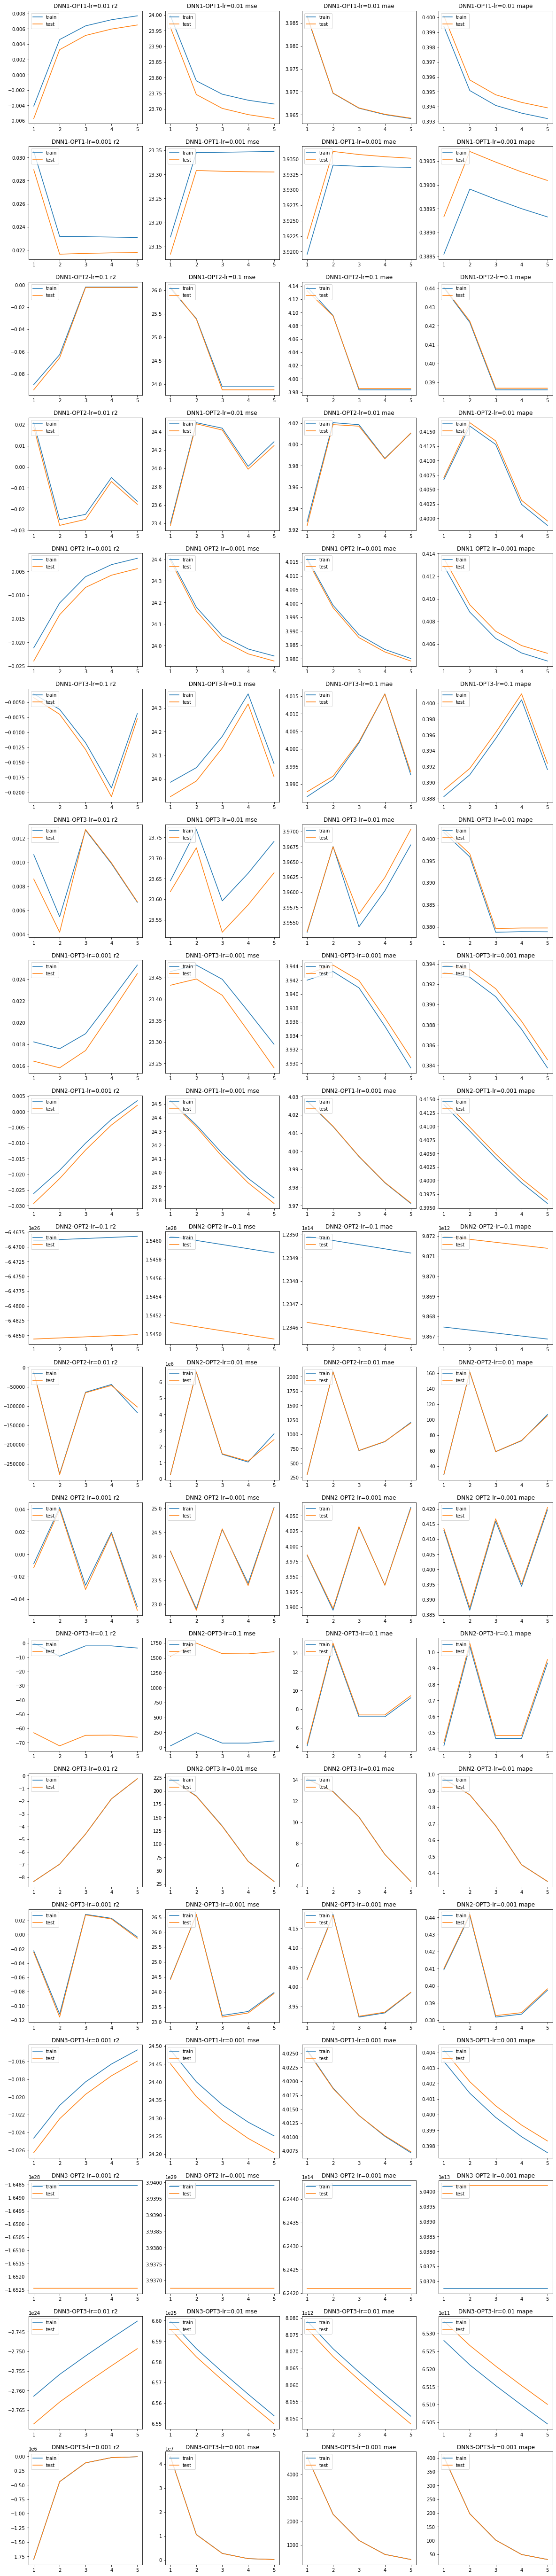

In [122]:
import matplotlib.pyplot as plt

h = correct_histories['DNN1-OPT3-lr=0.1']

metrics_arr = ['r2', 'mse', 'mae', 'mape']

fig, ax = plt.subplots(len(correct_histories), len(metrics_arr), figsize=[20,100])

h_index = 0

for k, v in correct_histories.items():
    for m_index, m in enumerate(metrics_arr):
        ax[h_index, m_index].plot(v[f'{m} train'], label='train')
        ax[h_index, m_index].plot(v[f'{m} test'], label='test')
        ax[h_index, m_index].set_title(f'{k} {m}')
        ax[h_index, m_index].xlabel = 'epoch'
        ax[h_index, m_index].legend(loc='upper left')
    h_index += 1

plt.show()

__Висновки__: Як бачимо, декілька поєднань неромережа-оптимізатор-швидкість_навчання не підходили один одному і давали похибку NaN. Це були поєднання з більшою швидкістю навчання. Найоптимальнішими виявились поєднання з одним прихованим шаром. Приблизно такі ж графіки давали поєднання 25_шарів + лр=0.001. При всіх інших комбінаціях точність скаче від епохи до епохи (можливо для вирішення проблеми варто спробувати більшу кількість епох).